In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CelebA
from torchvision.transforms import ToTensor, Compose, CenterCrop, Normalize
from tqdm import tqdm
from matplotlib import pyplot as plt

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_set = CelebA('./dataset', split='train', transform=Compose([
        CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

val_set = CelebA('./dataset', split='test', transform=Compose([
        CenterCrop((128, 128)),
        ToTensor(),
        Normalize(.5, .5),
    ]), download=True)

Files already downloaded and verified
Files already downloaded and verified


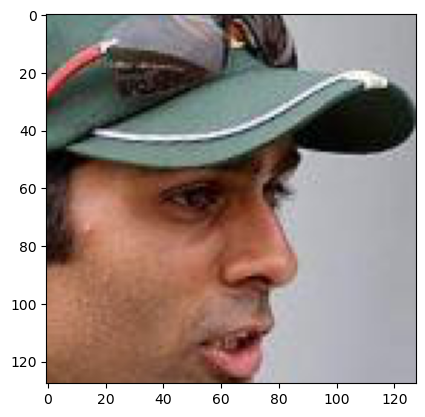

In [3]:
def showimgs(imgs):
    #plt.figure(figsize=(20, 10))
    imgs = imgs.movedim((0, 2, 3, 1), (0, 1, 2, 3))
    imgs = np.concatenate(imgs.detach().numpy().tolist(), axis=1)
    imgs = (imgs + 1)/2
    plt.imshow(imgs)


#img, label = train_set[np.random.randint(0, len(train_set))]

BS = 64
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
batch, _ = next(iter(train_loader))
showimgs(batch[:10])

In [4]:
from model import DenoisingDiffusion
import os

def get_model():
    try:
        chks = os.listdir('./chkpnts')
        ns = [int(chk.split('checkpnt_epoch-')[1].split('.pt')[0])
             for chk in chks]
        if len(ns) == 0:
            raise Exception()
        n = sorted(ns)[-1]
        return torch.load(f'chkpnts/checkpnt_epoch-{n}.pt')
    except Exception:
        return DenoisingDiffusion(diffusion_steps=1000, dev=dev)

In [5]:
model = get_model()
n = model.forward_process(batch)
#showimgs(n)
#showimgs(img := model.backward_process(n))
sum(param.numel() for param in model.parameters())

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1617.14it/s]


141385702